In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 检查 CUDA 是否可用
print(f"CUDA available: {torch.cuda.is_available()}")

# 如果 CUDA 可用，打印当前设备名称
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")

# 获取 CUDA 版本
cuda_version = torch.version.cuda
print(f"CUDA Version: {cuda_version}")

# 获取 cuDNN 版本
cudnn_version = torch.backends.cudnn.version()
print(f"cuDNN Version: {cudnn_version}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self,x):
        x=self.net(x)
        return x
        
class SinCosLayer(nn.Module):
    def __init__(self, W):
        super(SinCosLayer, self).__init__()
        self.W = W
    def forward(self, x):
        sin_x = torch.sin(2 * torch.pi * torch.matmul(x, self.W))
        cos_x = torch.cos(2 * torch.pi * torch.matmul(x, self.W))
        return torch.cat((sin_x, cos_x), dim=1)
        
class FF_MLP(nn.Module):
    def __init__(self, hidden_channle, output_dim, W1, W2):
        super(FF_MLP, self).__init__()
        self.FFlayer_T = SinCosLayer(W1)
        self.FFlayer_X = SinCosLayer(W2)
        self.EncoderNet = nn.Sequential(
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh()
        )
        self.OutNet = nn.Sequential(
            nn.Linear(hidden_channle*2, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, data):
        # t = data[:,0].reshape(-1,1)
        # x = data[:,1].reshape(-1,1)
        # H1 = self.FFlayer_T(t)
        # H2 = self.FFlayer_X(x)
        
        H1 = self.FFlayer_T(data)
        H2 = self.FFlayer_X(data)
        
        H1 = self.EncoderNet(H1)
        H2 = self.EncoderNet(H2)
        H = torch.cat((H1, H2), dim = 1)
        out = self.OutNet(H)
        return out

CUDA available: True
Current device: NVIDIA GeForce GTX 1650
CUDA Version: 11.8
cuDNN Version: 90100
cuda


In [3]:
class PINN_Vibratec:
    def __init__(self, m, EI, ET, hidden_channle, output_dim):
        self.m = m
        self.EI = EI
        self.ET = ET
        self.hidden_channle = hidden_channle
        self.output_dim = output_dim
        self.Losses = []
        self.file_name = 'C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\PINNs_ElasticMechanics\\PINNs_Vibrate_2D.pkl'
        # self.model = self.get_Model()
        self.model = MLP(2,60,1).to(device)

    def get_Model(self):
        W1 = (torch.randn(2, self.hidden_channle//2, requires_grad=False, dtype=torch.float32) * 1).to(device)
        W2 = (torch.randn(2, self.hidden_channle//2, requires_grad=False, dtype=torch.float32) * 10).to(device)
        model = FF_MLP(self.hidden_channle, self.output_dim, W1, W2).to(device)
        return model
        
    def u_function(self, t, x):
        out = self.model(torch.hstack((t, x)))
        u = out[:,0:1]
        return u

    def u_grad(self, data):
        t = data[:,0:1]
        x = data[:,1:2]
        u = self.u_function(t, x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx, x, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
        u_xxxx = torch.autograd.grad(u_xxx, x, torch.ones_like(u_xxx), retain_graph=True, create_graph=True)[0]

        u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), retain_graph=True, create_graph=True)[0]
        return u, u_t, u_tt, u_x, u_xx, u_xxx, u_xxxx
    
    def pde_Loss(self, data):
        u, _, u_tt, _, u_xx, _, u_xxxx = self.u_grad(data)
        Fy = self.f_function(data)
        temp = self.m * u_tt + self.EI * u_xxxx - self.ET * u_xx - Fy
        loss = torch.mean(torch.square(temp))
        return loss

    def data_Loss(self, data, u_data):
        # t = data[:,0:1]
        # x = data[:,1:2]
        # u = self.u_function(t, x)
        u, _, u_tt, _, u_xx, _, u_xxxx = self.u_grad(data)
        loss = torch.mean(torch.square(u-u_data))
        return loss
        
    def f_function(self, data):
        t = data[:,0:1]
        x = data[:,1:2]
        f = (-4*self.m+16*self.EI+4*self.ET)*torch.sin(2*t)*torch.sin(2*x)
        return f

    def u_Exact(self, data):
        t = data[:,0:1]
        x = data[:,1:2]
        u = torch.sin(2*t)*torch.sin(2*x)
        return u.cpu().detach().numpy()

    def train(self, x_pde, x_data, u_data, epochs, learning_rate, step_size=400, gamma=0.5):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            pdeloss = self.pde_Loss(x_pde)
            dataloss = self.data_Loss(x_data, u_data)
            loss = pdeloss + dataloss
            loss.backward()
            self.Losses.append(loss.item())
            self.optimizer.step()
            self.scheduler.step()
            if epoch % 100 == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item():.8f}]")
                torch.save(self.model.state_dict(), self.file_name)
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}] [pde_loss: {pdeloss.item()}] [data_loss: {dataloss.item()}]")
        torch.save(self.model.state_dict(), self.file_name)
        return loss

    def plot_loss(self):
        plt.title('log(loss)')
        plt.plot(np.log(self.Losses), label = 'Loss')
        plt.legend()
        plt.show()
        
    def predict(self, data):
        t = data[:,0:1]
        x = data[:,1:2]
        u = self.u_function(t, x)
        u = u.cpu().detach().numpy()
        return u
        
    def plot_result(self, data):
        t_np = data[:,0:1].cpu().detach().numpy()
        x_np = data[:,1:2].cpu().detach().numpy()
        u_np = self.predict(data)
        u_ex = self.u_Exact(data)

        print(f"Total Loss:{np.mean(np.square(u_np-u_ex))}")
        
        plt.figure(figsize=(18,4))
        plt.subplot(1,3,1)
        plt.scatter(t_np, x_np, c = u_np, cmap='bwr')
        plt.colorbar()
        plt.xlabel('T')
        plt.ylabel('X')
        plt.title('Predict')
        plt.tight_layout()
        
        plt.subplot(1,3,2)
        plt.scatter(t_np, x_np, c = u_ex, cmap='bwr')
        plt.colorbar()
        plt.xlabel('T')
        plt.ylabel('X')
        plt.title('Exact')
        plt.tight_layout()

        plt.subplot(1,3,3)
        plt.scatter(t_np, x_np, c = np.abs(u_np-u_ex), cmap='bwr')
        plt.colorbar()
        plt.xlabel('T')
        plt.ylabel('X')
        plt.title('Abstract Error')
        plt.tight_layout()
        
        plt.show()

[Epoch 1/2000] [loss: 62.77766800]
[Epoch 101/2000] [loss: 1.84561384]
[Epoch 201/2000] [loss: 0.13728139]
[Epoch 301/2000] [loss: 0.17542028]
[Epoch 401/2000] [loss: 0.07040055]
[Epoch 501/2000] [loss: 0.02174368]
[Epoch 601/2000] [loss: 0.01656498]
[Epoch 701/2000] [loss: 0.01288950]
[Epoch 801/2000] [loss: 0.01013201]
[Epoch 901/2000] [loss: 0.00900595]
[Epoch 1001/2000] [loss: 0.00800136]
[Epoch 1101/2000] [loss: 0.00711782]
[Epoch 1201/2000] [loss: 0.00634994]
[Epoch 1301/2000] [loss: 0.00600214]
[Epoch 1401/2000] [loss: 0.00566959]
[Epoch 1501/2000] [loss: 0.00535331]
[Epoch 1601/2000] [loss: 0.00505386]
[Epoch 1701/2000] [loss: 0.00490864]
[Epoch 1801/2000] [loss: 0.00476359]
[Epoch 1901/2000] [loss: 0.00461915]
[Epoch 2000/2000] [loss: 0.004477155394852161] [pde_loss: 0.0018890710780397058] [data_loss: 0.002588084200397134]


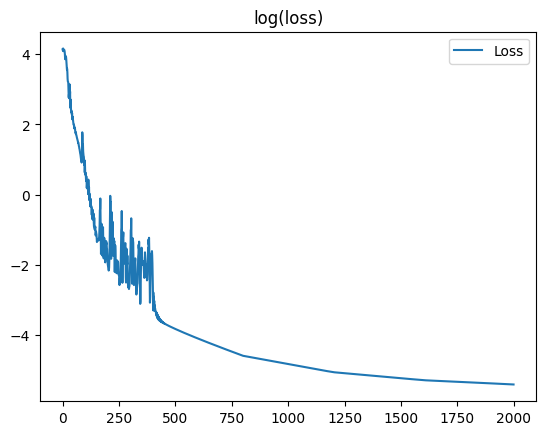

Total Loss:0.011603445746004581


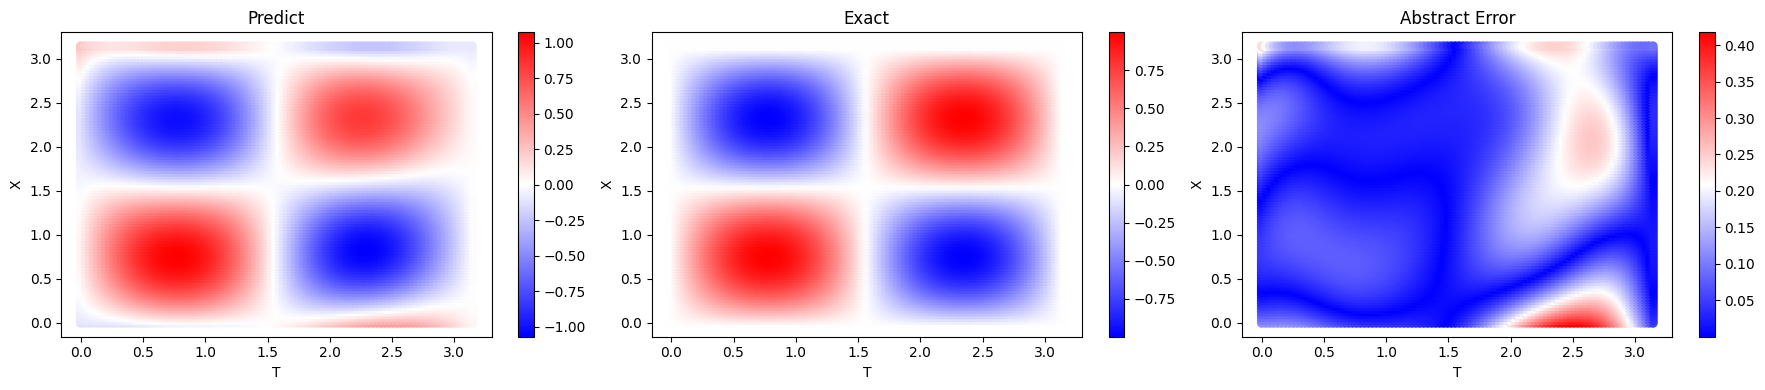

In [4]:
ms = 1
EI = 1
ET = 1
# ms*u_tt+EI*u_ssss-ET*u_ss=Fy

T = np.pi
L = np.pi
N_t = 100
N_s = 100
t = np.linspace(0, T, N_t)
s = np.linspace(0, L, N_s)
t, s = np.meshgrid(t, s)
pde_t = t.reshape(-1, 1)
pde_s = s.reshape(-1, 1)
X_pde = torch.tensor(np.hstack((pde_t, pde_s)), dtype=torch.float32, requires_grad=True).to(device)

data_t1 = np.zeros((N_t,1))
data_s1 = np.linspace(0, L, N_s).reshape(-1, 1)
x_data_left = np.hstack((data_t1, data_s1))
u_data_left = np.zeros((N_t,1))

data_t2 = np.ones((N_t,1)) * np.pi
data_s2 = np.linspace(0, L, N_s).reshape(-1, 1)
x_data_right = np.hstack((data_t2, data_s2))
u_data_right = np.zeros((N_t,1))

data_t3 = np.ones((N_t,1)) * np.pi/2
data_s3 = np.linspace(0, L, N_s).reshape(-1, 1)
x_data_mid = np.hstack((data_t3, data_s3))
u_data_mid = np.zeros((N_t,1))

data_t4 = np.ones((N_t,1)) * np.pi/4
data_s4 = np.linspace(0, T, N_t).reshape(-1, 1)
x_data_h = np.hstack((data_t4, data_s4))
u_data_h = np.sin(2*data_s4)

x_data = np.vstack((x_data_left,x_data_mid,x_data_right,x_data_h))
u_data = np.vstack((u_data_left,u_data_mid,u_data_right,u_data_h))
X_data = torch.tensor(x_data, dtype=torch.float32, requires_grad=True).to(device)
U_data = torch.tensor(u_data, dtype=torch.float32, requires_grad=True).to(device)

PINNs_model = PINN_Vibratec(ms, EI, ET, 50, 1)
loss = PINNs_model.train(x_pde = X_pde, x_data = X_data, u_data = U_data, epochs = 2000, learning_rate = 1e-2, step_size=400, gamma=0.5)
PINNs_model.plot_loss()
PINNs_model.plot_result(X_pde)

[Epoch 1/10000] [loss: 0.00238919]
[Epoch 101/10000] [loss: 0.00230812]
[Epoch 201/10000] [loss: 0.00225206]
[Epoch 301/10000] [loss: 0.00220804]
[Epoch 401/10000] [loss: 0.00211433]
[Epoch 501/10000] [loss: 0.00204430]
[Epoch 601/10000] [loss: 0.00197489]
[Epoch 701/10000] [loss: 0.00227804]
[Epoch 801/10000] [loss: 0.00184314]
[Epoch 901/10000] [loss: 0.00180213]
[Epoch 1001/10000] [loss: 0.00172374]
[Epoch 1101/10000] [loss: 0.00169445]
[Epoch 1201/10000] [loss: 0.00166434]
[Epoch 1301/10000] [loss: 0.00163357]
[Epoch 1401/10000] [loss: 0.00160227]
[Epoch 1501/10000] [loss: 0.00157057]
[Epoch 1601/10000] [loss: 0.00153858]
[Epoch 1701/10000] [loss: 0.00150641]
[Epoch 1801/10000] [loss: 0.00147411]
[Epoch 1901/10000] [loss: 0.00144177]
[Epoch 2001/10000] [loss: 0.00140945]
[Epoch 2101/10000] [loss: 0.00139309]
[Epoch 2201/10000] [loss: 0.00137629]
[Epoch 2301/10000] [loss: 0.00135907]
[Epoch 2401/10000] [loss: 0.00134145]
[Epoch 2501/10000] [loss: 0.00132343]
[Epoch 2601/10000] [loss

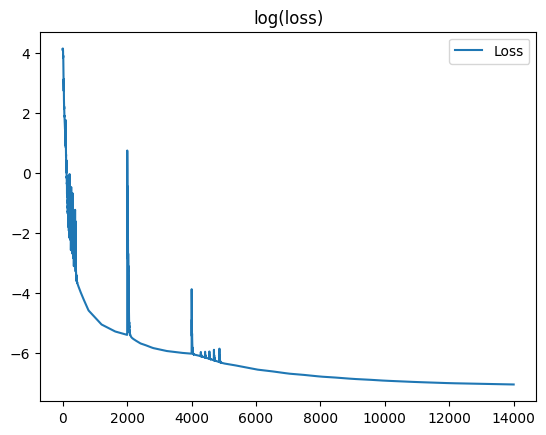

Total Loss:0.002771372441202402


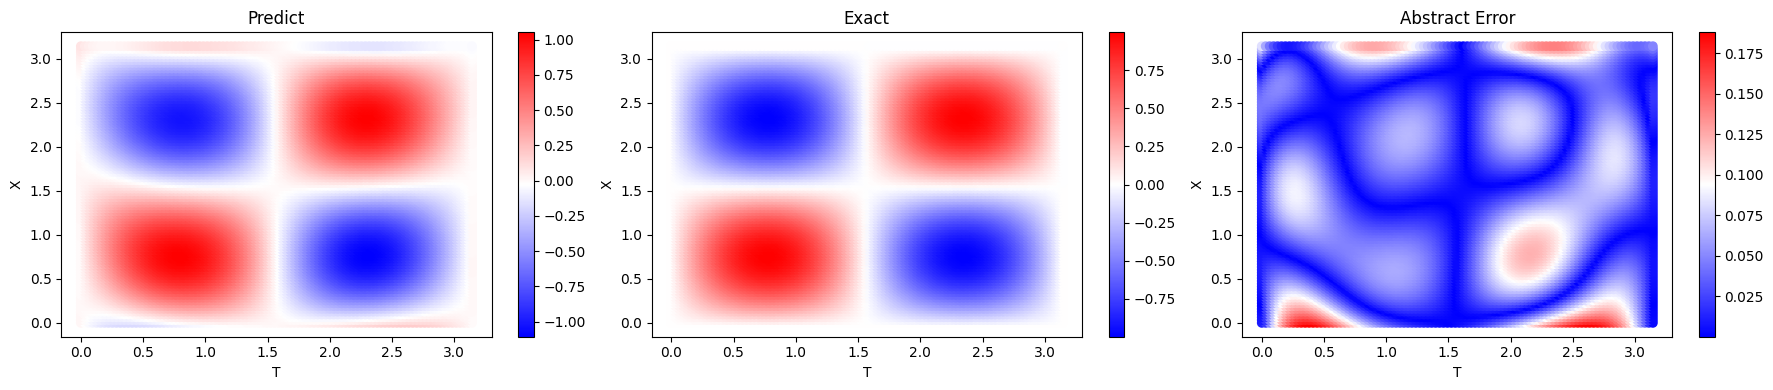

In [8]:
loss = PINNs_model.train(x_pde = X_pde, x_data = X_data, u_data = U_data, epochs = 10000, learning_rate = 1e-4, step_size=1000, gamma=0.5)
PINNs_model.plot_loss()
PINNs_model.plot_result(X_pde)